<a href="https://colab.research.google.com/github/jxin11/waste-image-classification/blob/main/Waste_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Import Libraries

In [ ]:
pip install visualkeras

In [ ]:
pip install helper

In [ ]:
import cv2
import glob
import random
import visualkeras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow import keras
from collections import Counter
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score

# Read & Store Images

In [ ]:
!git clone https://github.com/garythung/trashnet

Cloning into 'trashnet'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 42 (delta 4), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (42/42), done.


In [ ]:
!unzip /content/trashnet/data/dataset-resized.zip

In [ ]:
SIZE = 128

images = []
labels = []

for folder_path in glob.glob("/content/dataset-resized/*"):
  label = folder_path.split("/")[-1]
  for img_path in glob.glob(folder_path + "/*.jpg"):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (SIZE, SIZE))   # Resize image
    images.append(img)
    labels.append(label)

In [ ]:
print("Total no. of images: ", len(images))
print("Total no. of labels: ", len(labels))
print("Total no. of unique labels: ", Counter(labels))

Total no. of images:  2527
Total no. of labels:  2527
Total no. of unique labels:  Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})


# Prepare Train & Test Sets

In [ ]:
# Shuffle images
temp = list(zip(images, labels))
random.seed(0)
random.shuffle(temp)
res1, res2 = zip(*temp)
images, labels = list(res1), list(res2)

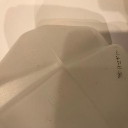

plastic


In [ ]:
i = 1327
cv2_imshow(images[i])
print(labels[i])